<a href="https://colab.research.google.com/github/EstebanAG1005/Laboratorio6-Gan-DS/blob/main/Lab6_DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install kaggle

In [7]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:12<00:00, 28.8MB/s]
100% 1.33G/1.33G [00:12<00:00, 111MB/s] 


In [8]:
!unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [9]:
import numpy as np
import pandas as pd
import os, cv2
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.models import Model
from keras.optimizers import RMSprop, Adam
import keras.backend as K

In [10]:
image_list = glob('img_align_celeba/img_align_celeba/*')
len(image_list)

202599

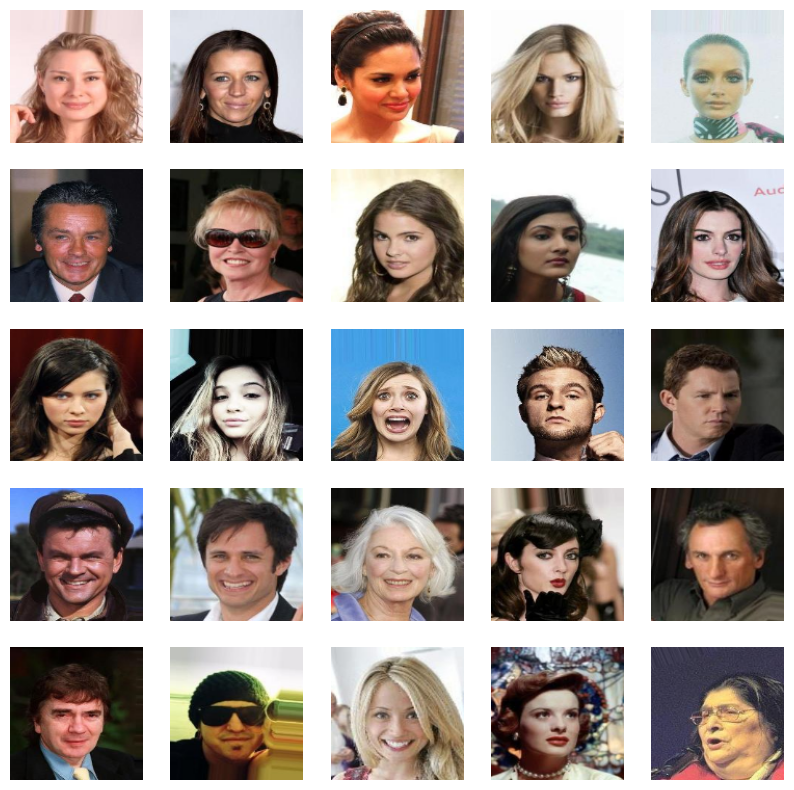

In [11]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    img = cv2.imread(image_list[i])[:,:,::-1]
    img = cv2.resize(img, (128, 128))
#     img = (img - 127.5)/127.5
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [12]:
img.shape

(128, 128, 3)

In [13]:
images = []
for i in tqdm(image_list[:10000]):
    img = cv2.imread(i)[:,:,::-1]
    img = cv2.resize(img, (128, 128))
    img = (img - 127.5)/127.5
    images.append(img)

100%|██████████| 10000/10000 [00:17<00:00, 572.63it/s]


In [14]:
# images.pop()
images = np.asarray(images)
images.shape

(10000, 128, 128, 3)

In [15]:
from keras.layers import Activation, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Conv2DTranspose
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, UpSampling2D, Flatten, Dropout, BatchNormalization

In [16]:
LATENT_DIM = 100
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x, name='model_Gen')
    return generator

In [17]:
generator = create_generator()

In [18]:
!rm -rf /kaggle/working/res2

In [19]:
import os
import numpy as np
import time

iters = 10000
batch_size = 32
LATENT_DIM = 100
CHANNELS = 3

RES_DIR = '/kaggle/working/res2'
FILE_PATH = '%s/generated_%d.png'

# Changed to os.makedirs to create parent directories if needed
os.makedirs(RES_DIR, exist_ok=True)

# Added check to create a file if it doesn't exist
# Assuming `images_saved` is the identifier/index for the file name
images_saved = 0  # Should be defined before its use
generated_file_path = FILE_PATH % (RES_DIR, images_saved)
if not os.path.exists(generated_file_path):
    with open(generated_file_path, 'w') as f:  # 'w' will create the file if it doesn't exist
        pass  # Empty block, the file is created/overwritten with no content.

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
WIDTH, HEIGHT = 128, 128
start = 0
d_losses = []
a_losses = []
# images_saved = 0  # Moved this above, before its first usage


In [20]:
HEIGHT, WIDTH, CHANNELS = 128, 128, 3  # Example dimensions, adjust as needed

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(32, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(64, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x, name='model_Disc')

    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=10000,  # You might adjust this value according to your use case
        decay_rate=0.9)  # You might adjust this value according to your use case

    optimizer = RMSprop(
        learning_rate=lr_schedule,
        clipvalue=1.0
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator


In [21]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

discriminator = create_discriminator()#input_shape = (128, 128, 3))
discriminator.trainable = False

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

# Your GAN model definition here...
gan_input = Input(shape=(LATENT_DIM, ))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = Model(gan_input, gan_output, name='model_GAN')
gan.summary()

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

# Define the optimizer using `learning_rate` parameter
optimizer = Adam(
    learning_rate=lr_schedule  # Using `learning_rate` parameter with decay
)

# Compile your GAN model
gan.compile(optimizer=optimizer, loss='binary_crossentropy')


Model: "model_GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_Gen (Functional)      (None, 128, 128, 3)       17182211  
                                                                 
 model_Disc (Functional)     (None, 1)                 5146689   
                                                                 
Total params: 22328900 (85.18 MB)
Trainable params: 17182211 (65.54 MB)
Non-trainable params: 5146689 (19.63 MB)
_________________________________________________________________


In [23]:
!pip install tqdm

In [1]:
import time
import numpy as np
from tqdm import tqdm
# Asegúrate de importar las demás librerías necesarias para tu código

start_time = time.time()
images_saved = 0  # Asegúrate de inicializar esta variable si no lo has hecho anteriormente

# Usa tqdm para crear una barra de progreso
for step in tqdm(range(iters), desc="Training Progress"):
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        print('*'*100)
        print('%d/%d: d_loss: %.6f,  g_loss: %.6f,  (%.2f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        start_time = time.time()

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)

        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8((control_image*127.5) + 127.5))
        plt.imshow(im)
        plt.show()
        print('*'*100)

        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

# Guarda los pesos del modelo después de que el bucle ha terminado
gan.save_weights('/kaggle/working/gan_final.h5')


NameError: ignored